In [2]:
import torch

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import trange
import torch
import seaborn as sns
import os
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import sklearn
import time
import datetime

plt.style.use("seaborn")
torch.set_default_dtype(torch.float32)

/tmp/ipykernel_2284375/505789997.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [4]:
import node

ModuleNotFoundError: No module named 'node'

In [5]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score

In [44]:
from hypertab import Hypernetwork
from hypertab.interfaces import HypernetworkSklearnInterface
# from ipynb.fs.defs.MNIST_benchmark import test_model

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [7]:
from sklearn.metrics import classification_report, balanced_accuracy_score

In [8]:
import pyhopper

In [9]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

1

In [10]:
import seaborn as sns

In [11]:
DEVICE="cuda:0"

# Load data

In [29]:
DATA = "Libras"

In [46]:
if DATA == "Ionosphere":
    ionosphere = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data', header=None)
    ionosphere = ionosphere.drop(1, axis=1)
    X = ionosphere.values[:, :-1].astype(float)
    y = ionosphere.values[:, -1]
    y = LabelEncoder().fit_transform(y).astype(int)
    #(351, 33) 2 #auc roc
    GS_METRIC = "roc_auc"
    
elif DATA == "Libras":
    libras = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data', header=None)
    X = libras.values[:, :-1].astype(float)
    y = libras.values[:, -1].astype(int)
    y -= 1
    #(360, 90) 15
    GS_METRIC = "balanced_accuracy"
    
elif DATA == "Lymphography":
    lymphography = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/lymphography/lymphography.data', header=None)
    X = lymphography.values[:, 1:].astype(float)
    y = lymphography.values[:, 0].astype(int)
    y -= 1
    #(148, 18) 4
    GS_METRIC = "balanced_accuracy"
    
    X, y = imblearn.over_sampling.SMOTE(
                        sampling_strategy={0:10, 3:20}, 
                        random_state=42,
                        k_neighbors=1,
                    ).fit_resample(X, y)
    
elif DATA == "Cleveland":
    dataset = pd.read_csv("../data/Cleveland/processed.cleveland.data", header=None, na_values="?").dropna()
    X = dataset.values[:, :-1].astype(float)
    y = dataset.values[:, -1].astype(int)
    y[y>0] = 1
    y = LabelEncoder().fit_transform(y).astype(int)
    GS_METRIC = "balanced_accuracy"
    
print(X.shape, len(np.unique(y)))


(360, 90) 15


In [47]:
n_classes = len(np.unique(y))
n_classes

15

In [48]:
unique, counts = np.unique(y, return_counts=True)

print(dict(zip(unique, counts)))

{0: 24, 1: 24, 2: 24, 3: 24, 4: 24, 5: 24, 6: 24, 7: 24, 8: 24, 9: 24, 10: 24, 11: 24, 12: 24, 13: 24, 14: 24}


In [49]:
n_features = X.shape[1]
n_features

90

In [50]:
max_size = int(len(X)*0.7)

In [51]:
print('dataset size:', len(X), '|', 'max training size:', max_size)

dataset size: 360 | max training size: 251


In [52]:
TEST_RUN = False

# Preprocess

In [19]:
np.random.seed(42)

def prepare_data(X, y, size=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y)
    # X_train, y_train = imblearn.over_sampling.RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train, X_test, y_train, y_test = [torch.from_numpy(x) for x in [X_train, X_test, y_train, y_test]]
    
    return X_train, X_test, y_train, y_test

In [20]:
X_train, X_test, y_train, y_test = prepare_data(X, y, size=max_size)

## Benchmark

In [21]:
criterion = torch.nn.CrossEntropyLoss()

In [22]:
def _summarize_results(y_pred, y_score, y_test, labels):
    results = []
    for idx, label in enumerate(labels):
        y_pred_filt = y_pred[y_test==idx]
        y_test_filt = y_test[y_test==idx]
        acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
        results.append({
            "Class": label,
            "Metric": acc
        })
        
    acc = (y_pred==y_test.numpy()).sum()/len(y_test)*100    
    results.append({
        "Class": "Total",
        "Metric": acc
    })
    
    
    results.append({
        "Class": "balanced_accuracy",
        "Metric": balanced_accuracy_score(y_test, torch.from_numpy(y_pred)).item()*100
    })
    
    try:
        results.append({
            "Class": "F1 score",
            "Metric": f1_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "roc_auc",
            "Metric": roc_auc_score(y_test, torch.from_numpy(y_score[:, 1])).item()*100
        })
        results.append({
            "Class": "Precision",
            "Metric": precision_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "Recall",
            "Metric": recall_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
    except ValueError:
        pass
    return results

def test_model(model_fn, data, train_size, label_encoder=None, iters=10, as_numpy=False):
    if TEST_RUN:
        iters = 1
        
    if label_encoder is not None:
        labels = label_encoder.classes_
    else:
        labels = sorted(pd.unique(data[1]))
    
    results = []

    for i in range(iters):
        print('iter', i+1, 'of', iters)

        X_train, X_test, y_train, y_test = prepare_data(*data, train_size)
        
        model = model_fn()

        if as_numpy:
            model.fit(X_train.numpy(), y_train.numpy());
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        results.extend(_summarize_results(y_pred, y_score, y_test, labels))

    dframe = pd.DataFrame.from_dict(results)
    sns.violinplot(data=dframe[dframe["Class"]!="Loss"], y="Class", x="Metric", orient='h')
    return dframe

### Param search

In [23]:
def grid_search_best_params(model_fn, param_grid, data_size=max_size, scoring=GS_METRIC):
    if TEST_RUN:
        tmp = {k: [v[0]] for k, v in param_grid.items()}
        param_grid = tmp
        
    X_train, X_test, y_train, y_test = prepare_data(X, y, data_size)

    cv_clf = GridSearchCV(
        estimator=model_fn(), 
        param_grid=param_grid,
        scoring=scoring, 
        return_train_score=True,
        verbose=1, 
        cv=5,
    )

    res = cv_clf.fit(X_train, y_train)

    print(f'best params for {DATA}', res.best_params_)
    print('mean_train_score', cv_clf.cv_results_['mean_train_score'].mean())
    print('std_train_score', cv_clf.cv_results_['std_train_score'].mean())

    predictions = cv_clf.predict(X_test) 
    print(classification_report(y_test, predictions))
    
    with open(f"{DATA}_{model_fn.__name__}_best_params.txt", "a") as f:
            f.write(str(res.best_params_) + ", " + str(balanced_accuracy_score(y_test, predictions)) + "\n")
    
    print(f"{DATA}_{model_fn.__name__}_{res.best_params_}")
    
    return res.best_params_

In [24]:
def pyhopper_best_params(model_fn, param_grid, data_size=max_size, metric=GS_METRIC, time="1min"):
    if TEST_RUN:
        time = 60
        
    def objective(params):
    #     print("Training...")
        model_results = test_model(
                        model_fn(
                            **params
                        ),
                        (X, y),
                        data_size,
                        None, 5)
        with open(f"{DATA}_{model_fn.__name__}_params.txt", "a") as f:
            f.write(str(params) + ", " + str(model_results[model_results["Class"]==metric]["Metric"].mean()) + "\n")
        return model_results[model_results["Class"]==metric]["Metric"].mean()

    from pyhopper.callbacks import History
    search = pyhopper.Search(param_grid)

    best_params = search.run(objective, "maximize", time, seeding_ratio=0.5)
    
    with open(f"{DATA}_{model_fn.__name__}_best_params.txt", "a") as f:
            f.write(str(best_params))
    
    print(f"{DATA}_{model_fn.__name__}_{best_params}")
    return best_params


# TRAIN MODELS

### XGBoost

In [24]:
from xgboost import XGBClassifier

In [26]:
import xgboost
xgboost.__version__

'1.7.3'

In [27]:
def get_xgboost(**params):
    random_seed = np.random.randint(1024)
    def _inner():
        return XGBClassifier(
            verbosity=0,
            random_state=random_seed,
            use_label_encoder=False,
            **params
        )
    return _inner    

#### Hyperparam tuning

  0%|          | [00:00<?]

Search is scheduled for 01:00 (m:s)
iter 1 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 3 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 4 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 5 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 1 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 3 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 4 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 5 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 1 of 5
iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samp

iter 3 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 4 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


iter 5 of 5
iter 1 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 3 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 4 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 5 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 1 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 3 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 4 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 5 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 1 of 5
iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 3 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 4 of 5
iter 5 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 1 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 3 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 4 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 5 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 1 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 3 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 4 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 5 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 1 of 5
iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 3 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 4 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 5 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 1 of 5
iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samp

iter 3 of 5
iter 4 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: User

iter 5 of 5
iter 1 of 5
iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 3 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 4 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 5 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 1 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 3 of 5
iter 4 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 5 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 1 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 3 of 5
CTRL+C received. Will terminate once the currently running candidates finished


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 4 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 5 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


================= Summary =================
Mode              : Best f : Steps : Time  
----------------  : ----   : ----  : ----  
Initial solution  : 82.35  : 1     : 2.23 s
Random seeding    : 85     : 12    : 28 s  
----------------  : ----   : ----  : ----  
Total             : 85     : 13    : 30 s  
Cleveland_get_xgboost_{'n_estimators': 2150, 'max_depth': 10, 'learning_rate': 0.0004912549854491816, 'min_child_weight': 16, 'gamma': 0}


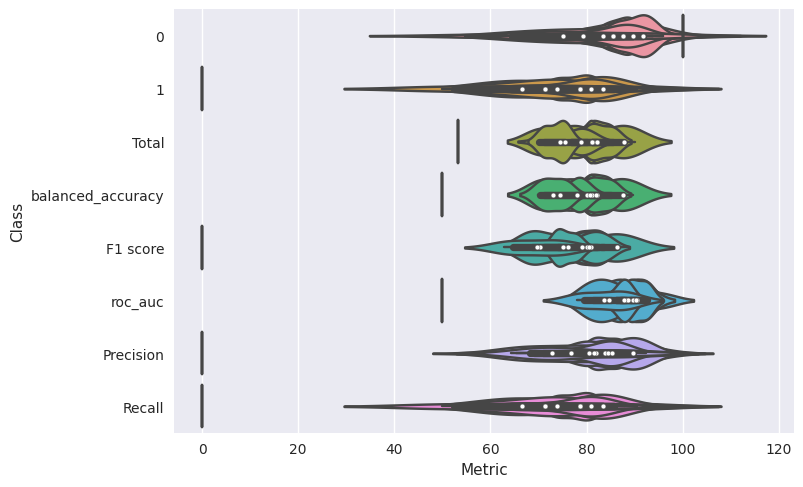

In [40]:
param_grid = {
                'n_estimators': pyhopper.int(50, 3000, multiple_of=50),
                'max_depth': pyhopper.choice([2, 3, 5, 10, 15]),
                'learning_rate': pyhopper.float(1e-5,1e-1, log=True),
                'min_child_weight': pyhopper.choice([1, 2, 4, 8, 16, 32]),
                'gamma': pyhopper.choice([0, 0.001, 0.1, 1]),
             }

xgbc = get_xgboost()

xgbt_best1 = pyhopper_best_params(get_xgboost, param_grid)

In [41]:
xgbt_best1

{'n_estimators': 2150,
 'max_depth': 10,
 'learning_rate': 0.0004912549854491816,
 'min_child_weight': 16,
 'gamma': 0}

iter 1 of 10


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 2 of 10


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 3 of 10


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 4 of 10


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 5 of 10


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 6 of 10


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 7 of 10


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 8 of 10


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 9 of 10


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 10 of 10


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


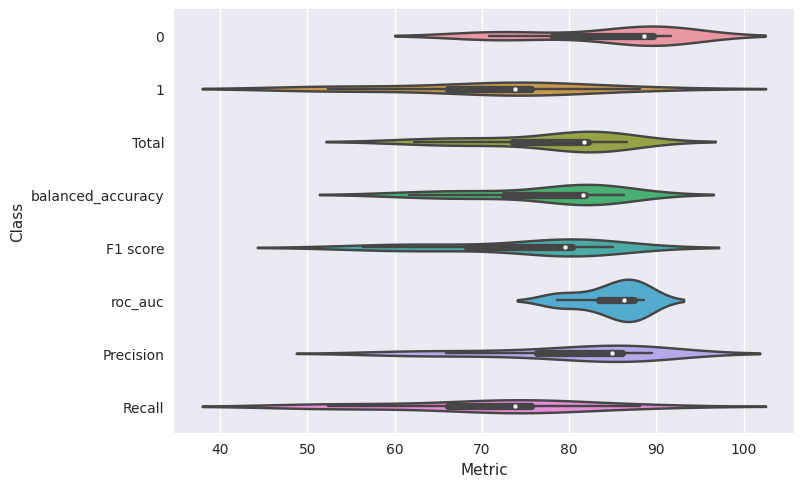

In [42]:
xgbc = get_xgboost(**xgbt_best1)

xgbt_best2 = test_model(xgbc, (X, y), max_size)

In [68]:
xgbt_best2

,Class,Metric
0,0,85.416667
1,1,69.047619
2,Total,77.777778
3,balanced_accuracy,77.232143
4,F1 score,74.358974
...,...,...
75,balanced_accuracy,81.101190
76,F1 score,80.000000
77,roc_auc,89.434524
78,Precision,79.069767


#### Best Params

'Ionosphere' {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 1500}


iter 1 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 2 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 3 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 4 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


iter 5 of 5


/home/MCB/wwydmanski/miniconda3/envs/img_processing/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


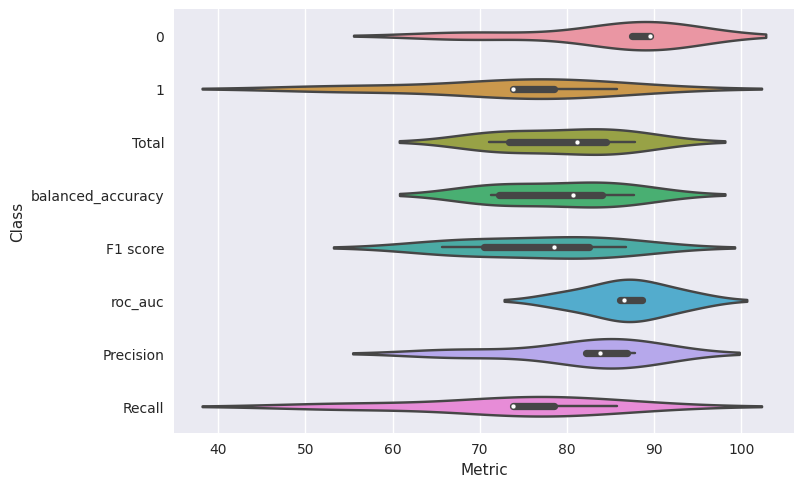

In [43]:
data_size = max_size

xgb_dframe = test_model(get_xgboost(**xgbt_best1),
                        (X, y),
                        data_size,
                        label_encoder=None, iters=5)

In [44]:
res = xgb_dframe[xgb_dframe["Class"]=="balanced_accuracy"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

207: 79.17 ~ 7.24 (max: 87.65)


In [73]:
xgb_dframe.groupby(['Class']).mean()

,Metric
Class,
0,81.250000
1,74.761905
F1 score,76.231300
Precision,78.059743
Recall,74.761905
Total,78.222222
balanced_accuracy,78.005952
roc_auc,88.487103


### NODE

In [36]:
from qhoptim.pyt import QHAdam

In [71]:
def node_fn(layer_dim=128, num_layers=1, depth=3):
    def _inner():
        network = torch.nn.Sequential(
            node.DenseBlock(X_train.shape[1], 
                            layer_dim=layer_dim,
                            num_layers=num_layers, 
                            tree_dim=n_classes+1, 
                            depth=depth, 
                            flatten_output=False,
                            choice_function=node.entmax15, 
                            bin_function=node.entmoid15
                           ),
            node.Lambda(lambda x: x.mean(dim=1))
        )
        
        with torch.no_grad():
            res = network(torch.as_tensor(X_train, device='cpu').to(torch.float32))
        
        network = network.to(DEVICE)
        network.device=DEVICE
            
        optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
        optim = QHAdam(network.parameters(), **optimizer_params)
            
        network = SimpleSklearnInterface(network, device=DEVICE, epochs=150, batch_size=32)
        network.optimizer = optim
        return network
    return _inner

#### Tune hyperparams

  0%|          | [00:00<?]

Search is scheduled for 01:00 (m:s)
iter 1 of 1


/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:72: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bin_codes = (indices.view(1, -1) // offsets.view(-1, 1) % 2).to(torch.float32)
/home/z1157095/hypernet-cnn/deps/node/node/lib/odst.py:113: UserWarning: Data-aware initialization is performed on less than 1000 data points. This may cause instability.To avoid potential problems, run this model on a data batch with at least 1000 data samples.You can do so manually before training. Use with torch.no_grad() for memory efficiency.
  warn("Data-aware initialization is performed on less than 1000 data points. This may cause instability."


================ Summary ================
Mode              : Best f : Steps : Time
----------------  : ----   : ----  : ----
Initial solution  : 89.16  : 1     : 40 s
----------------  : ----   : ----  : ----
Total             : 89.16  : 1     : 40 s
Ionosphere_node_fn_{'layer_dim': 256, 'num_layers': 3, 'depth': 4}


{'layer_dim': 256, 'num_layers': 3, 'depth': 4}

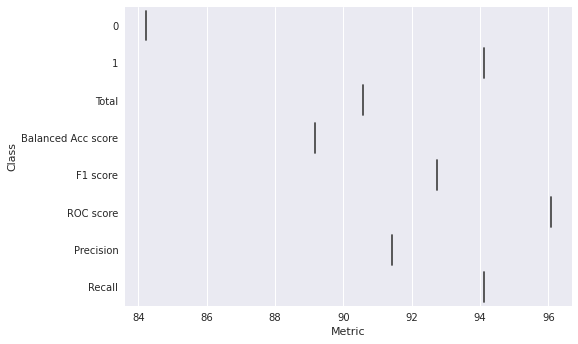

In [72]:
# 'layer_dim': hp.quniform('layer_dim', 100, 1200, 100),
# 'num_layers': hp.quniform('num_layers', 1, 4, 1),
# 'depth': hp.quniform('depth', 2, 7, 1)
                    
param_grid = {
    'layer_dim': pyhopper.int(64, 1024, power_of=2),
    'num_layers': pyhopper.int(1, 5),
    'depth': pyhopper.int(2, 7),
}

node_best = pyhopper_best_params(node_fn, param_grid, time="90m")
node_best

#### Use best hyperparams

In [73]:
%%capture --no-stdout

size=max_size

node_results = test_model(node_fn(**node_best),
                    (X, y),
                    size,
                    label_encoder=None, iters=10)
res = node_results[node_results["Class"]=="roc_auc"].reset_index(drop=True)["Metric"]
print(f"{size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

iter 1 of 1
245: 97.52 ~ nan, (max: 97.52)


### Dropout Neural network

In [40]:
def network_fn1(epochs=100, drop1=0.3, drop2=0.5, batch_size=32, lr=3e-4):
    
    def _inner():
        network = torch.nn.Sequential(
                        torch.nn.Dropout(drop1),
                        torch.nn.Linear(n_features, 64),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop2),
                        torch.nn.Linear(64, n_classes)
                    ).to(DEVICE).train()

        network = SimpleSklearnInterface(network, epochs=epochs, batch_size=batch_size, lr=3e-4)
        return network
    return _inner



def network_fn2(epochs=100, drop1=0.3, drop2=0.5, drop3=0.5, batch_size=32, lr=3e-4):
    
    def _inner():
        network = torch.nn.Sequential(
                        torch.nn.Dropout(drop1),
                        torch.nn.Linear(n_features, 64),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop2),
                        torch.nn.Linear(64, 64),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop3),
                        torch.nn.Linear(64, n_classes)
                    ).to(DEVICE).train()

        network = SimpleSklearnInterface(network, epochs=epochs, batch_size=batch_size, lr=3e-4)
        return network
    return _inner



def network_fn3(epochs=100, drop1=0.3, drop2=0.5, drop3=0.5, drop4=0.5, batch_size=32, lr=3e-4):
    
    def _inner():
        network = torch.nn.Sequential(
                        torch.nn.Dropout(drop1),
                        torch.nn.Linear(n_features, 64),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop2),
                        torch.nn.Linear(64, 128),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop3),
                        torch.nn.Linear(128, 64),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(drop4),
                        torch.nn.Linear(64, n_classes)
                    ).to(DEVICE).train()

        network = SimpleSklearnInterface(network, epochs=epochs, batch_size=batch_size, lr=3e-4)
        return network
    return _inner

#### Find Hyperparams

### Dropout 1 layer

  0%|          | [00:00<?]

Search is scheduled for 01:00 (m:s)
iter 1 of 1
iter 1 of 1
iter 1 of 1
iter 1 of 1
==================== Summary ===================
Mode              : Best f : Steps : Time       
----------------  : ----   : ----  : ----       
Initial solution  : 84.06  : 1     : 15.58 s    
Random seeding    : 81.42  : 1     : 14.31 s    
Local sampling    : 91.37  : 2     : 31 s       
----------------  : ----   : ----  : ----       
Total             : 91.37  : 4     : 01:01 (m:s)
Ionosphere_network_fn1_{'epochs': 100, 'drop1': 0.3, 'drop2': 0.1, 'lr': 3e-05, 'batch_size': 32}


{'epochs': 100, 'drop1': 0.3, 'drop2': 0.1, 'lr': 3e-05, 'batch_size': 32}

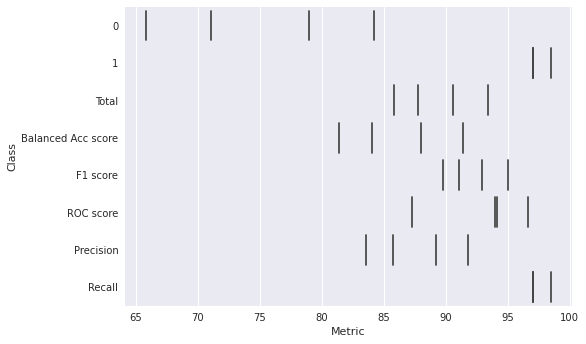

In [41]:
param_grid = {
                "epochs": pyhopper.choice([100, 150]),
                "drop1": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop2": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
                "batch_size": pyhopper.choice([32, 64]),
             }

nn_fn1_best_params = pyhopper_best_params(network_fn1, param_grid, time="60m")
nn_fn1_best_params

iter 1 of 1


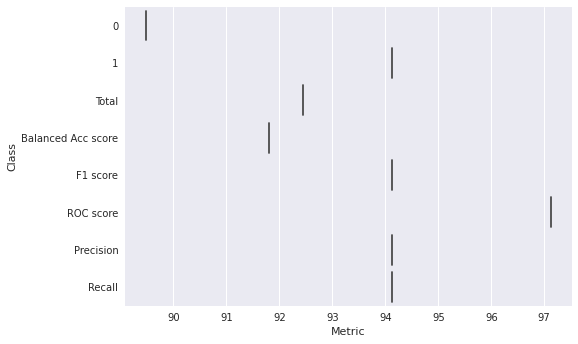

In [42]:
data_size = max_size

nn1_results = test_model(network_fn1(**nn_fn1_best_params),
                (X, y),
                data_size,
                None, 10)

In [43]:
res = nn1_results[nn1_results["Class"]=="Balanced Acc score"]["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

245: 91.80 ~ nan (max: 91.80)


### Dropout 2 layers

  0%|          | [00:00<?]

Search is scheduled for 01:00 (m:s)
iter 1 of 1
iter 1 of 1
iter 1 of 1
==================== Summary ===================
Mode              : Best f : Steps : Time       
----------------  : ----   : ----  : ----       
Initial solution  : 89.47  : 1     : 15.85 s    
Random seeding    : 92.69  : 1     : 22 s       
Local sampling    : 87.27  : 1     : 24 s       
----------------  : ----   : ----  : ----       
Total             : 92.69  : 3     : 01:02 (m:s)
Ionosphere_network_fn2_{'epochs': 150, 'drop1': 0.5, 'drop2': 0.5, 'drop3': 0.3, 'lr': 0.003, 'batch_size': 64}


{'epochs': 150,
 'drop1': 0.5,
 'drop2': 0.5,
 'drop3': 0.3,
 'lr': 0.003,
 'batch_size': 64}

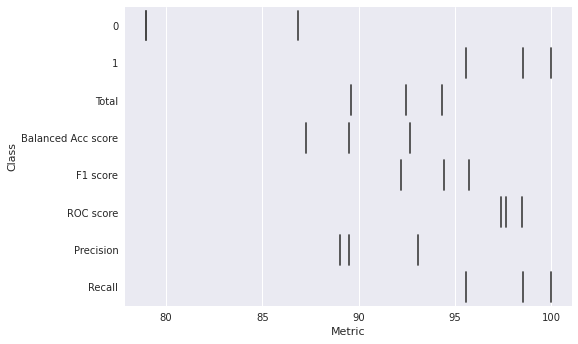

In [44]:
param_grid = {
                "epochs": pyhopper.choice([100, 150]),
                "drop1": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop2": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop3": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
                "batch_size": pyhopper.choice([32, 64]),
             }

nn_fn2_best_params = pyhopper_best_params(network_fn2, param_grid, time="70m")
nn_fn2_best_params

iter 1 of 1


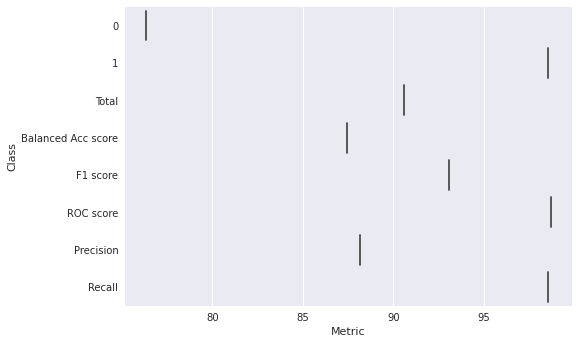

In [45]:
data_size = max_size

nn2_results = test_model(network_fn2(**nn_fn2_best_params),
                (X, y),
                data_size,
                None, 10)

### Dropout 3 layers

  0%|          | [00:00<?]

Search is scheduled for 01:00 (m:s)
iter 1 of 1
iter 1 of 1
iter 1 of 1
================== Summary =================
Mode              : Best f : Steps : Time   
----------------  : ----   : ----  : ----   
Initial solution  : 86.11  : 1     : 16.66 s
Random seeding    : 83.48  : 1     : 22 s   
Local sampling    : 92.69  : 1     : 14.81 s
----------------  : ----   : ----  : ----   
Total             : 92.69  : 3     : 54 s   
Ionosphere_network_fn3_{'epochs': 100, 'drop1': 0.3, 'drop2': 0.3, 'drop3': 0.3, 'drop4': 0.3, 'lr': 3e-05, 'batch_size': 64}


{'epochs': 100,
 'drop1': 0.3,
 'drop2': 0.3,
 'drop3': 0.3,
 'drop4': 0.3,
 'lr': 3e-05,
 'batch_size': 64}

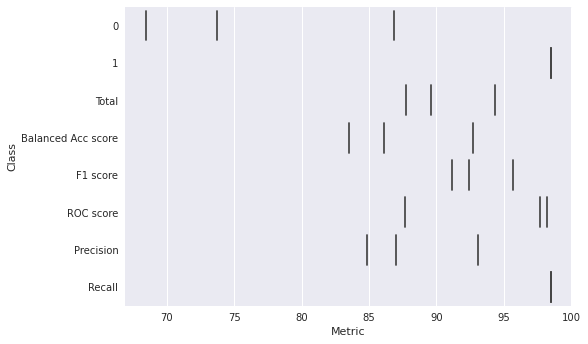

In [46]:
param_grid = {
                "epochs": pyhopper.choice([100, 150]),
                "drop1": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop2": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop3": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "drop4": pyhopper.choice([0.1, 0.3, 0.5, 0.7], is_ordinal=True),
                "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
                "batch_size": pyhopper.choice([32, 64]),
             }

nn_fn3_best_params = pyhopper_best_params(network_fn3, param_grid, time="75m")
nn_fn3_best_params

iter 1 of 1


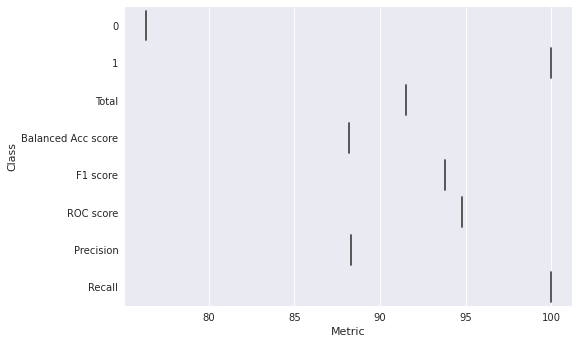

In [47]:
data_size = max_size

nn3_results = test_model(network_fn3(**nn_fn3_best_params),
                (X, y),
                data_size,
                None, 10)

### HypernetworkPCA

In [48]:
def network_pca_fn(epochs=100, masks_no=100, mask_size=100, target_size=100, n_comp=5, lr=3e-4, batch_size=64):
    def _inner():
        hypernet = HypernetworkPCA(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)], 
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_comp, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                        input_size=n_features
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=False, lr=3e-4)
        return network
    return _inner

In [49]:
def figure_to_html():
    tmpfile = BytesIO()
    plt.gcf().savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    return html

In [50]:
X.shape[1] // 7

4

#### Find hyperparams

  0%|          | [00:00<?]

Search is scheduled for 01:00 (m:s)
iter 1 of 1
torch.Size([1, 128])
33
==================== Summary ===================
Mode              : Best f : Steps : Time       
----------------  : ----   : ----  : ----       
Initial solution  : 91.37  : 1     : 02:22 (m:s)
----------------  : ----   : ----  : ----       
Total             : 91.37  : 1     : 02:22 (m:s)
Ionosphere_network_pca_fn_{'epochs': 100, 'masks_no': 50, 'mask_size': 11, 'target_size': 5, 'n_comp': 5, 'lr': 3e-05, 'batch_size': 32}


{'epochs': 100,
 'masks_no': 50,
 'mask_size': 11,
 'target_size': 5,
 'n_comp': 5,
 'lr': 3e-05,
 'batch_size': 32}

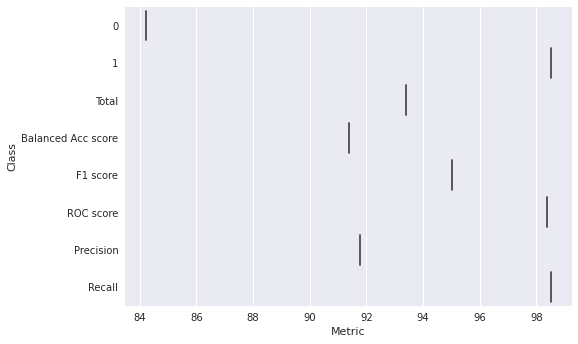

In [51]:
param_grid = {
    "epochs": pyhopper.choice([100, 150]),
    "masks_no": pyhopper.int(10, 100, multiple_of=10),
    "mask_size": pyhopper.int(3, 20),
    "target_size": pyhopper.choice([5, 10, 20, 50]),
    "n_comp": pyhopper.int(3, 15),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),

}

hp_pca_best_params = pyhopper_best_params(network_pca_fn, param_grid, time="90m")
hp_pca_best_params

In [52]:
hp_pca_best_params

{'epochs': 100,
 'masks_no': 50,
 'mask_size': 11,
 'target_size': 5,
 'n_comp': 5,
 'lr': 3e-05,
 'batch_size': 32}

'Libras'
{'epochs': 150,
 'masks_no': 70,
 'mask_size': 20,
 'target_size': 10,
 'n_comp': 10}

'Lymphography' {'epochs': 120, 'masks_no': 50, 'mask_size': 4, 'target_size': 20, 'n_comp': 6}

In [53]:
DATA

'Ionosphere'

Ionosphere
{'epochs': 100, 'masks_no': 60, 'mask_size': 5, 'target_size': 10}


iter 1 of 1
torch.Size([1, 128])
33


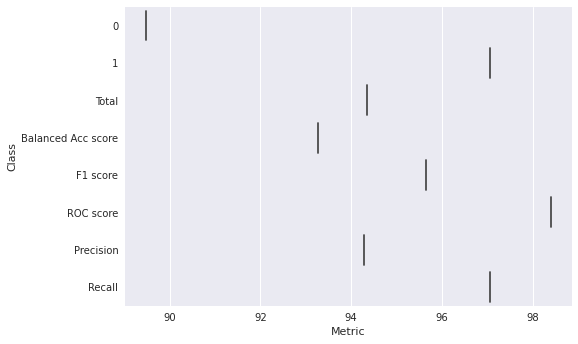

In [54]:
epochs = hp_pca_best_params['epochs']
masks_no = hp_pca_best_params['masks_no']
mask_size = hp_pca_best_params['mask_size']
target_size = hp_pca_best_params['target_size']
n_comp = hp_pca_best_params['n_comp']
data_size = max_size

nn_pca_results = test_model(network_pca_fn(target_size=target_size, mask_size=mask_size, masks_no=masks_no, n_comp=n_comp),
                (X, y),
                data_size,
                None, 10)

# exp.log_table("metrics.csv", nn_pca_results.groupby("Class").mean())
# exp.log_metric("f1_score", nn_pca_results.groupby("Class").mean().loc["F1 score"])

In [55]:
res = nn_pca_results[nn_pca_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

245: 94.34 ~ nan (max: 94.34)


### Hypernetwork

In [55]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=10, target_size=100, lr=3e-4, batch_size=64):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=False, lr=3e-4)
        return network
        # hypernet = HyperTabClassifier(epochs=epochs, device=DEVICE, batch_size=batch_size, lr=3e-4, subsample=subsample, test_nodes=masks_no)
        # return hypernet
    return _inner

#### Find hyperparams

  0%|          | [00:00<?]

Search is scheduled for 01:30:00 (h:m:s)
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
====================== Summary ======================
Mode              : Best f : Steps : Time            
----------------  : ----   : ----  : ----            
Initial solution  : 67.95  : 1     : 16:20 (m:s)     
Random seeding    : 76.56  : 2     : 39:22 (m:s)     
Local sampling    : 85.75  : 1     : 18:36 (m:s)     
----------------  : ----   : ----  : ----            
Total             : 85.75  : 4     : 01:14:18 (h:m:s)
Libras_network_hp_fn_{'epochs': 100, 'masks_no': 70, 'mask_size': 25, 'target_size': 50, 'lr': 0.003, 'batch_size': 64}


{'epochs': 100,
 'masks_no': 70,
 'mask_size': 25,
 'target_size': 50,
 'lr': 0.003,
 'batch_size': 64}

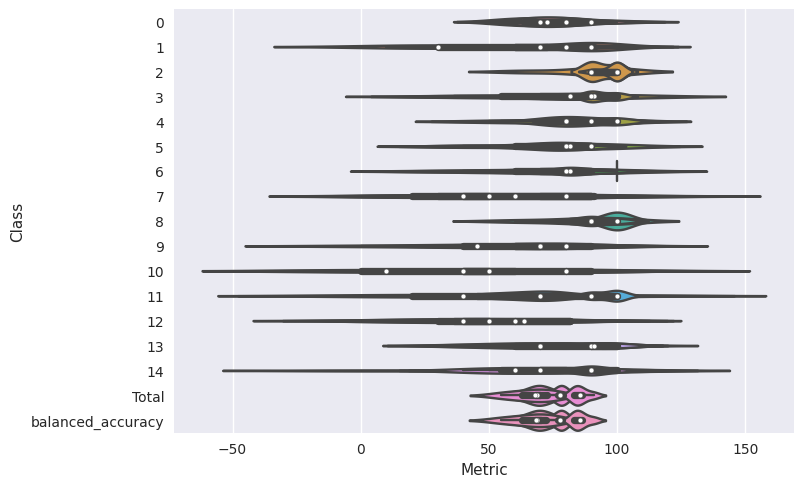

In [56]:
param_grid = {
    "epochs": pyhopper.choice([100, 150]),
    "masks_no": pyhopper.int(10, 100, multiple_of=10),
    "mask_size": pyhopper.int(5, 70, multiple_of=5),
    "target_size": pyhopper.choice([5, 10, 20, 50]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),
}

hp_best_params = pyhopper_best_params(network_hp_fn, param_grid, time="90m")
hp_best_params

#### Train using the best hyperparams

iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5


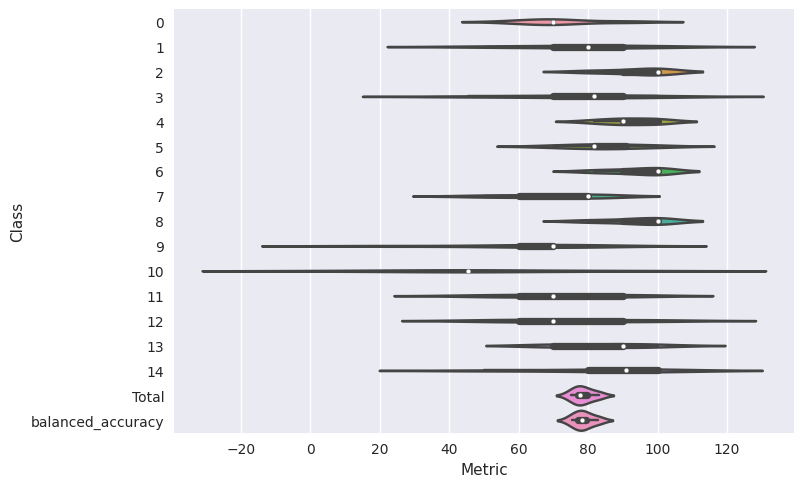

In [33]:
# epochs = hp_best_params['epochs']
# masks_no = hp_best_params['masks_no']
# mask_size = hp_best_params['mask_size']
# target_size = hp_best_params['target_size']
data_size = max_size

def get_hypernet():
    return HyperTabClassifier(0.4, device="cuda:0", similarity_loss=False)

hyper_results = test_model(get_hypernet,
                    (X, y),
                    data_size,
                    None, 5, True)

In [34]:
res = hyper_results[hyper_results["Class"]=="balanced_accuracy"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

207: 78.64 ~ 2.86, (max: 82.91)


### Random forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
def get_rf(**params):
    random_seed = np.random.randint(1024)
    def _inner():
        return RandomForestClassifier(
            random_state=random_seed,
            **params
        )
    return _inner

#### Find hyperparams

In [ ]:
param_grid = {
                'n_estimators': pyhopper.int(50, 3000, multiple_of=50),
                'max_features': pyhopper.choice([None, 'sqrt', 0.2, 0.3, 0.5, 0.7]),
                'criterion' : pyhopper.choice(['gini', 'entropy']),
                'max_depth': pyhopper.choice([None, 2, 4, 8, 16]),
             }
rf = get_rf()

rf_best = pyhopper_best_params(get_rf, param_grid)
rf_best

  0%|          | [00:00<?]

Search is scheduled for 01:00 (m:s)
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5
iter 1 of 5
iter 2 of 5
CTRL+C received. Will terminate once the currently running candidates finished
iter 3 of 5


In [49]:
rf_best

{'n_estimators': 2650,
 'max_features': 0.7,
 'criterion': 'entropy',
 'max_depth': 16}

#### Use best params

iter 1 of 5
iter 2 of 5
iter 3 of 5
iter 4 of 5
iter 5 of 5


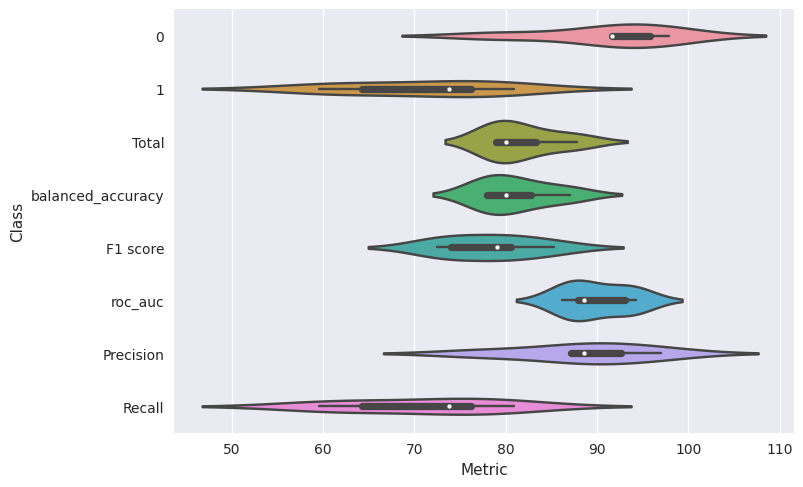

In [51]:
size = max_size

rf_dframe = test_model(get_rf(**rf_best), 
                        (X, y),
                        size,
                        None, iters=5)

In [52]:
res = rf_dframe[rf_dframe["Class"]=="balanced_accuracy"].reset_index(drop=True)["Metric"]
print(f"{data_size}: {res.mean():.2f} ~ {res.std():.2f} (max: {res.max():.2f})")

207: 81.10 ~ 3.89 (max: 87.05)


# Collect analytics

In [67]:
d = {}

In [68]:
d['Random forest'] = rf_dframe.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Hypernet'] = hyper_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['HypernetPCA'] = nn_pca_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Dropout_1'] = nn1_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Dropout_2'] = nn2_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Dropout_3'] = nn3_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['Node'] = node_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])
d['XGBoost'] = xgb_dframe.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])

In [69]:
all_models_df=pd.concat(d, axis=0)
all_models_df

mean  std        max
              Class                                        
Random forest 0                   86.842105  NaN  86.842105
              1                   91.176471  NaN  91.176471
              Balanced Acc score  89.009288  NaN  89.009288
              F1 score            91.851852  NaN  91.851852
              Precision           92.537313  NaN  92.537313
...                                     ...  ...        ...
XGBoost       F1 score            93.333333  NaN  93.333333
              Precision           94.029851  NaN  94.029851
              ROC score           96.381579  NaN  96.381579
              Recall              92.647059  NaN  92.647059
              Total               91.509434  NaN  91.509434

[64 rows x 3 columns]

In [ ]:
os.environ['COMET_KEY'] = ''

In [ ]:
exp = Experiment(os.environ.get("COMET_KEY"), 'hypernet-uci-tune')
exp.log_parameters({"epochs": epochs, "mask_size": mask_size, "masks_no": masks_no, "data_size": data_size})
exp.add_tag(f"hypernet-tune1{DATA}")
exp.log_table(f"{DATA}_metrics.csv", all_models_df)

In [ ]:
all_models_df.to_csv(f"{DATA}_metrics.csv")

In [86]:
f"{DATA}_metrics.csv"

'Lymphography_metrics.csv'

In [84]:
# all_models_df = pd.read_csv(f"{DATA}_metrics.csv")

In [71]:
all_models_df

mean  std        max
              Class                                        
Random forest 0                   81.578947  NaN  81.578947
              1                   94.117647  NaN  94.117647
              Balanced Acc score  87.848297  NaN  87.848297
              F1 score            92.086331  NaN  92.086331
              Precision           90.140845  NaN  90.140845
...                                     ...  ...        ...
XGBoost       F1 score            93.333333  NaN  93.333333
              Precision           94.029851  NaN  94.029851
              ROC score           96.381579  NaN  96.381579
              Recall              92.647059  NaN  92.647059
              Total               91.509434  NaN  91.509434

[64 rows x 3 columns]

In [72]:
tmp = all_models_df.reset_index()

In [73]:
tmp = tmp.rename(columns={'Unnamed: 0': DATA})